# Знакомство с данными

In [740]:
#Необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#Вспомогательные библиотеки
import re
# Отключил пердупреждения для чистоты вывода
from warnings import filterwarnings
filterwarnings("ignore")

In [741]:
main = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
main

,region,year,poverty_percent
0,Российская Федерация,1992,33.50
1,Российская Федерация,1993,31.30
2,Российская Федерация,1994,22.40
3,Российская Федерация,1995,24.80
4,Российская Федерация,1996,22.10
...,...,...,...
2334,Чукотский автономный округ,2017,8.50
2335,Чукотский автономный округ,2018,8.80
2336,Чукотский автономный округ,2019,8.50
2337,Чукотский автономный округ,2020,8.00


In [742]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           2339 non-null   object 
 1   year             2339 non-null   int64  
 2   poverty_percent  2339 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 54.9+ KB


Данные не содержат пропусков, типы данных присвоены правильно

In [743]:
main.describe()

,year,poverty_percent
count,2339.00,2339.00
mean,2007.80,20.24
std,7.43,13.36
min,1992.00,0.00
25%,2002.00,12.50
50%,2008.00,17.30
75%,2014.00,25.50
max,2020.00,98.40


Данные за 1992-2020 год, процент бедности от 0 до 98.4%

In [744]:
# Так как данные по следующим областям представлены в агрегированном виде до 2012 года, отставлю их так и удалю аггрегированные после 2011
main['region']=main['region'].apply(lambda x: x.strip())
main = main[~main.index.isin(main[(main['region']=='Архангельская область')][main.year>2011].index)]
main = main[~main.index.isin(main[(main['region']=='Тюменская область')][main.year>2011].index)]
short_dict={'Архангельская область': 'Архангельская область (кроме Ненецкого автономного округа)',
            'Тюменская область': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}
main.region = main.region.apply(lambda x: short_dict[x] if x in short_dict else x)

In [745]:
rf_main = main[main.region=='Российская Федерация'] # Сохраню отдельно данные по РФ перед удалением

In [746]:
def unified_regions(df):
    '''функция для отбора нужных регионов
    дополняется по мере знакомства с датасетами'''
    df = df.dropna(subset = 'region')
    df['region']=df['region'].apply(lambda x: x.strip())
    # Удалим аггрегационные данные (округа и две области, содержащие регионы)
    df=df.loc[~(df['region'].str.contains('федеральный'))&
                    ~(df['region'] == 'Архангельская область')&
                    ~(df['region'] == 'Тюменская область')&
                    ~(df['region'] == 'Российская Федерация'),:]

    # Сократим названия
    def find_similar(s):
        mydict={'оскв':'Город Москва',
            'етербург': 'Город Санкт-Петербург',
            'евастополь': 'Город Севастополь',
            'город Севастополь': 'Город Севастополь',
            'Архангельская область ': 'Архангельская область [кроме..]',
            'Тюменская область ': 'Тюменская область [кроме..]',
            'Чувашская Республика': 'Чувашская Республика - Чувашия',
            'Ханты-Мансийский авт':'Ханты-Мансийский автономный округ - Югра',
            'Кемеровская область':'Кемеровская область - Кузбасс',
            ' Саха':'Республика Саха'}
        for key in mydict:
            if key in s:
                return (mydict[key])
        return (s)
    df.region = df.region.apply(find_similar)
    df.region  = df.region.apply(lambda x: re.sub(r' \([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', x))
    df.region  = df.region.str.replace('авт. округ', 'автономный округ')
    df.region  = df.region.str.replace('авт. область', 'автономная область')
    df.region  = df.region.str.replace('B', 'В')
    return df

In [747]:
main = unified_regions(main)

In [748]:
main['poverty_percent'].value_counts(dropna=False)

poverty_percent
0.00     36
14.20    22
13.60    21
14.90    21
13.00    19
         ..
68.90     1
55.20     1
46.20     1
44.30     1
50.10     1
Name: count, Length: 474, dtype: int64

In [749]:
# Пробовал разные подходы к замене нулей, но в результате вижу самым логичным от них избавиться. Cделаю это после построения карты, а то некрасиво получается)
# main = main.replace(0,np.nan).dropna()

# EDA

## Интерактивная карта

Добавим регионы для отрисовки

In [750]:
# Код на географические координаты брал в интернете (может можно оптимизировать, но не хочу менять то, что работает)
from urllib.request import urlopen
import json
import requests
with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson') as response:
    counties = json.load(response)


regions_republic_1 = ['Бурятия', 'Тыва', 'Адыгея', 'Татарстан', 'Марий Эл', 'Алтай',
                      'Дагестан', 'Ингушетия', 'Башкортостан']
regions_republic_2 = ['Удмуртская республика', 'Кабардино-Балкарская республика',
                      'Карачаево-Черкесская республика', 'Чеченская республика']
for k in range(len(counties['features'])):
    counties['features'][k]['id'] = k
    if counties['features'][k]['properties']['name'] in regions_republic_1:
        counties['features'][k]['properties']['name'] = 'Республика ' + counties['features'][k]['properties']['name']
    elif counties['features'][k]['properties']['name'] in regions_republic_2:
        counties['features'][k]['properties']['name'] = counties['features'][k]['properties']['name'].title()
    elif counties['features'][k]['properties']['name'] == 'Архангельская область':
        counties['features'][k]['properties']['name'] = 'Архангельская область [кроме..]'        
    elif counties['features'][k]['properties']['name'] == 'Тюменская область':
        counties['features'][k]['properties']['name'] = 'Тюменская область [кроме..]'
    elif counties['features'][k]['properties']['name'] == 'Северная Осетия - Алания':
        counties['features'][k]['properties']['name'] = 'Республика Северная Осетия-Алания'
    elif counties['features'][k]['properties']['name'] == 'Чувашия':
        counties['features'][k]['properties']['name'] = 'Чувашская Республика - Чувашия'
    elif counties['features'][k]['properties']['name'] == 'Республика Саха (Якутия)':
        counties['features'][k]['properties']['name'] = 'Республика Саха'    
            
region_id_list = []
regions_list = []
for k in range(len(counties['features'])):
    region_id_list.append(counties['features'][k]['id'])
    regions_list.append(counties['features'][k]['properties']['name'])
df_regions = pd.DataFrame()
df_regions['region_id'] = region_id_list
df_regions['region'] = regions_list
short_dict={'Москва':'Город Москва',
            'Санкт-Петербург': 'Город Санкт-Петербург',
            'Город Санкт-Петербург город федерального значения': 'Город Санкт-Петербург',
            'Город федерального значения Севастополь': 'Город Севастополь',
            'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область [кроме..]',
            'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область [кроме..]',
            'Чувашская Республика': 'Чувашская Республика - Чувашия',
            'Ханты-Мансийский автономный округ':'Ханты-Мансийский автономный округ - Югра',
            'Кемеровская область':'Кемеровская область - Кузбасс'}
df_regions.region = df_regions.region.apply(lambda x: short_dict[x] if x in short_dict else x)

In [751]:
main = main.merge(df_regions, how='left', on=['region'])

In [ ]:
# Красивое, но лагает, раскомментить при необходимости или очистить вывод после просмотра

#строим график
fig = px.choropleth_mapbox(geojson=counties,
    data_frame=main,
    locations="region_id",
    color="poverty_percent",
    animation_frame="year",
    hover_data = {'region_id':False,'year':False, 'poverty_percent':True,'region':True},
    color_continuous_scale = "Temps",
    width=1000,
    height=600,
    center = {"lat": 66, "lon": 110}

)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),mapbox_style="carto-positron",mapbox_zoom=1.5)
fig.show()

# Сохраним результат
"""html = fig.to_html()
with open("figures/map.html", "w", encoding="utf-8") as f:
    f.write(html)"""

В некоторых регионах стабильно малый процент(Тюменская область и округа), где-то всегда большой (Республика Тыва). Заметен резкий спад процента по России в 2012. Но посмотрим подробнее

In [754]:
main = main.drop('region_id', axis =1)

## Процент бедности

In [755]:
# Удаляю нулевые проценты бедности
main = main.replace(0,np.nan).dropna()
# DF для визуализаций с РФ
vis = pd.concat([rf_main,main])

In [756]:
px.line(vis,
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [757]:
# Отрисуем регоны, которые лидировали по проценту бедности в какие-либо года
max_poverty_percent=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values('poverty_percent',ascending=False).head(1)], ignore_index = True)

px.line(vis[vis.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Видим, что всего три региона лидировали по доле бедности. Интересно, а если посмотреть топ-3?

In [758]:
max_poverty_percent=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values('poverty_percent',ascending=False).head(3)], ignore_index = True)

px.line(vis[vis.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Добавилось достаточно много областей, то есть в лидерах не всегда одни и те же. Заметно, что все их графики начинались выше среднего по России. Может это важно?

In [759]:
test = vis[(vis['year']==1995)&(vis['poverty_percent']>=24.8)] # 24.8 - Процент бедности в РФ в 1995 году

px.line(vis[vis.region.isin(test.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

По графику видно, что часть опустилась ниже среднего

In [760]:
test=test[test['region']!='Российская Федерация']
print(f'Регионы беднее среднего по России в 1995:', test.shape[0]-1)
test2 = vis[(vis.region.isin(test.region.unique()))&(vis['year']==2020)&(vis['poverty_percent']>=12.1)] # 12.1 - Процент бедности в РФ в 1995 году
print(f'Из них беднее среднего в 2020:', test2.shape[0])
test3 = vis[(~vis.region.isin(test.region.unique()))&(vis['year']==2020)&(vis['poverty_percent']>=12.1)]
print(f'Других регионов беднее среднего в России в 2020:', test3.shape[0])
print(f'Всего регионов беднее среднего в России в 2020:', test2.shape[0]+test3.shape[0])

Регионы беднее среднего по России в 1995: 48
Из них беднее среднего в 2020: 38
Других регионов беднее среднего в России в 2020: 19
Всего регионов беднее среднего в России в 2020: 57


Бедность в большинстве этих регионов так и осталась выше среднего, но судя по прибавлению других регионов к 2020, это не единственный определяющий фактор.
Перейдём от процентов к абсолютным числам населения

## Количество бедностей

In [761]:
# population.xlsx модифицировался вручную для удобства
pop = pd.read_excel('data/population_edit.xlsx')
pop.head()

,region,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Российская Федерация,147539426.00,146890128.00,146303611.00,145649334.00,144963650.00,144333586.00,143801046.00,143236582.00,142862692.00,...,143347059.00,143666931.00,146267288.00,146544710.00,146804372.00,146880432.00,146780720.00,146748590.00,146171015.00,145557576.00
1,Центральный федеральный округ,38311159.00,38227656.00,38175094.00,38068452.00,37946810.00,37965073.00,38044068.00,38109006.00,38183357.00,...,38678913.00,38819874.00,38951479.00,39104319.00,39209582.00,39311413.00,39378059.00,39433556.00,39250960.00,39104400.00
2,Белгородская область,1494868.00,1501699.00,1506976.00,1508137.00,1511899.00,1513860.00,1511662.00,1511715.00,1514153.00,...,1540985.00,1544108.00,1547936.00,1550137.00,1552865.00,1549876.00,1547418.00,1549151.00,1541259.00,1531917.00
3,Брянская область,1437471.00,1423178.00,1407965.00,1391430.00,1375004.00,1360249.00,1344132.00,1327652.00,1312748.00,...,1253666.00,1242599.00,1232940.00,1225741.00,1220530.00,1210982.00,1200187.00,1192491.00,1182682.00,1168771.00
4,Владимирская область,1592184.00,1575507.00,1558052.00,1539179.00,1520057.00,1509571.00,1497598.00,1486453.00,1475861.00,...,1421742.00,1413321.00,1405613.00,1397168.00,1389599.00,1378337.00,1365805.00,1358416.00,1342099.00,1323659.00


In [762]:
# Сократим названия
pop = unified_regions(pop.dropna(axis=0,subset='region'))

In [763]:
# конвертируем таблицу wide-to-long, уберем значения позже 2020
pop_df = pd.melt(pop,id_vars='region',var_name='year',value_name='population')
pop_df

,region,year,population
0,Белгородская область,1999,1494868.00
1,Брянская область,1999,1437471.00
2,Владимирская область,1999,1592184.00
3,Воронежская область,1999,2458558.00
4,Ивановская область,1999,1210603.00
...,...,...,...
2179,Амурская область,2022,772525.00
2180,Магаданская область,2022,137767.00
2181,Сахалинская область,2022,484177.00
2182,Еврейская автономная область,2022,153831.00


In [764]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))

set()

In [765]:
main = main.merge(pop_df, how='left', on=['region','year'])

In [766]:
#Заменим популяцию в старых годах первым доступным значением
main.population = main.population.bfill()

In [767]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) # делает читаемым числа
# добавим абсолютные значения бедного населения
main['poverty_population'] = main.poverty_percent*main.population/100

In [768]:
px.line(main,
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [769]:
max_main=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_main = pd.concat([max_main, df.sort_values('poverty_population',ascending=False).head(1)], ignore_index = True)
max_main
px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Тут ожидаемо Москва и МО берут числом

Отберём топ-регионов с наибольшим числом населения за чертой бедности

In [770]:
max_main=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_main = pd.concat([max_main, df.sort_values('poverty_population',ascending=False).head(5)], ignore_index = True)

px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

In [771]:
vis = main[main['year']==2020]
px.scatter(vis, x = 'poverty_population', y='poverty_percent', color='region')

До применения моделей можно сказать, каким регионам необходимо больше тратить на поддержку малообеспеченного населения

## Показатели социальной незащищенности

### Возраст

In [772]:
df_socdem = pd.DataFrame()
for year in range(2017,2021):
    socdem = pd.read_excel(f'data/poverty_socdem_{year}.xls',skiprows=[0,1])
    socdem = socdem.drop(['Все население','Население трудоспособного возраста'], axis=1) # удалил колонки не несущие новой информации
    socdem = socdem.rename({'Unnamed: 0': 'region', 'Дети в возрасте до 16 лет':'kids', "Население старше трудоспособного возраста": 'senior'},axis =1)
    socdem['year'] = year
    socdem = unified_regions(socdem)
    # Сократим названия
    df_socdem = pd.concat([df_socdem,socdem])
# Удалю строчки, в которых нули по всем соотношениям
df_socdem = df_socdem[(df_socdem.kids+df_socdem.senior)!=0]
df_socdem = df_socdem.sort_values(['region','year'])
# Тут чаще нет данных в поздних годах, так что применю ffill()
df_socdem = df_socdem.ffill()

In [773]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))


set()

In [774]:
main = main.merge(df_socdem, how='left', on=['region','year'])
main.year = main.year.apply(int)

In [775]:
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered')

Относительные и абсолютные количества бедностей не зависят от возрастного состава субъектов. (Да, то что бедность падала со временем мы видели по графикам - это же видно по корреляции)

### Инвалидности

In [776]:
disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled

,region,total,18_30,31_40,41_50,51_60,60_,date
0,Российская Федерация,11640873.00,550895.00,766054.00,1030652.00,2135436.00,7157836.00,2017-01-01
1,Центральный федеральный округ,3420310.00,118579.00,172662.00,257484.00,598102.00,2273483.00,2017-01-01
2,Белгородская область,223030.00,6318.00,10383.00,16596.00,37444.00,152289.00,2017-01-01
3,Брянская область,110418.00,4215.00,6568.00,10230.00,21481.00,67924.00,2017-01-01
4,Владимирская область,133352.00,4454.00,6811.00,9606.00,23322.00,89159.00,2017-01-01
...,...,...,...,...,...,...,...,...
6075,Еврейская автономная область,11669.00,629.00,1167.00,1447.00,1624.00,6802.00,2022-04-01
6076,Чукотский автономный округ,1671.00,177.00,220.00,301.00,366.00,607.00,2022-04-01
6077,Республика Саха (Якутия),51362.00,4186.00,5536.00,6957.00,10118.00,24565.00,2022-04-01
6078,Приморский край,100734.00,4885.00,9090.00,12536.00,15527.00,58696.00,2022-04-01


In [777]:
disabled['region']=disabled['region'].apply(lambda x: x.strip())
#оставим от даты только год
disabled = disabled[disabled['date'].str.contains('01-01')] 
disabled['year'] = disabled['date'].str[:4].astype(int)
# сомневаюсь, что число инвалидностей по возрастам для нас существенно
disabled.drop(disabled.columns[2:8],axis=1,inplace=True)
disabled = disabled[disabled['year']<2021]

In [778]:
# Вычисления для регионов матрешек
disabled.loc[disabled['region'] == 'Архангельская область','total'] = (disabled.loc[disabled['region'] == 'Архангельская область','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ненецкий автономный округ','total'].values)
disabled.region  = disabled.region.str.replace('Архангельская область', 'Архангельская область [кроме..]')
disabled.loc[disabled['region'] == 'Тюменская область','total'] = (disabled.loc[disabled['region'] == 'Тюменская область','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ханты-Мансийский автономный округ','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ямало-Ненецкий автономный округ','total'].values)
disabled.region  = disabled.region.str.replace('Тюменская область', 'Тюменская область [кроме..]')

disabled.rename({'total':'disabled'},axis=1,inplace=True)

In [779]:
disabled = unified_regions(disabled)

In [780]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(disabled.region.unique()))

set()

In [781]:
main = main.merge(disabled, how='left', on=['region','year'])

In [782]:
# Переведем disabled в долю от населения
main['disabled_percent']=main['disabled']/main['population']*100

In [783]:
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered')

Можно подумать, что процент бедных зависит от количества инвалидностей, но это скорее проявление мультиколлинеарности и малого числа данных. Прямая зависимость таргета от процента инвалидностей мала. То же наблюдается для процентов детей и пенсионеров.

In [784]:
px.imshow(main[main.year>2016].corr(numeric_only=True),color_continuous_scale='Bluered')

Да, на промежутке 4 лет процент бедности так же коррелирует с общим населением региона, как и с числом инвалидностей

### Жилищные условия

In [785]:
housing_space = pd.read_excel('data/housing_2020.xlsx')
#housing_space

In [786]:
housing_space = housing_space.rename({housing_space.columns[0]:'region'},axis=1)
housing_space['year'] = 2020

In [787]:
housing_space = unified_regions(housing_space)
sorted(set(main.region.unique())-(set(housing_space.region.unique())))

[]

In [788]:
# Не хочу добавлять данные в основной датасет, так тут всего один год. Буду рассматривать отдельно
test = main.iloc[:,:3].merge(housing_space, how='left', on=['region','year'])

In [789]:
# Посмотрю на заметные корреляции, потом переименую нужные колонки
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

poverty_percent                                                                                  1.00
Число жилых комнат в расчете на одно домохозяйство                                               0.51
Размер жилой площади в расчете на члена домохозяйства                                            0.25
в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность         0.15
Размер общей площади в расчете на члена домохозяйства                                            0.10
в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность   -0.01
в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности             -0.04
затруднились ответить                                                                           -0.09
year                                                                                            -0.60
Число домохозяйств, проживающих во всех типах жилых помещений                     

In [790]:
housing_space = housing_space.rename({housing_space.columns[7]:'living_space',
                          housing_space.columns[8]:'living_rooms'}, axis=1)
housing_space = housing_space.drop(housing_space.columns[1:7],axis=1)

In [791]:
housing_cond= pd.read_excel('data/housing_2020.xlsx',sheet_name=1)
#housing_cond

In [792]:
housing_cond = housing_cond.rename({housing_cond.columns[0]:'region'},axis=1)
housing_cond['year'] = 2020
housing_cond = housing_cond.replace('...',np.nan)
housing_cond = housing_cond.replace('...*',np.nan)


In [793]:
housing_cond = housing_cond.fillna(housing_cond.iloc[0])

In [794]:
housing_cond = unified_regions(housing_cond)
sorted(set(main.region.unique())-(set(housing_cond.region.unique())))
test = main.iloc[:,:3].merge(housing_cond, how='left', on=['region','year'])

In [795]:
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

poverty_percent                                                                                                                                                  1.00
из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить  свои  жилищные условия  другим способом                                 0.42
из них домохозяйства, собирающиеся улучшить свои жилищные условия                                                                                                0.41
из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания                                                   0.33
из них указавшие: на плохое или очень плохое состояние жилого помещения                                                                                          0.28
из них указавшие: на стесненность проживания                                                                                                                     0.25
из ч

In [796]:
housing_cond = housing_cond.rename({housing_cond.columns[2]:'improving_living_conditions',
                                      housing_cond.columns[-4]:'improving_living_conditions(other)', # Плохо понимаю смысл этого фактора, но такая хорошая корреляция!
                                      housing_cond.columns[5]:'cramped_and_bad_conditions',
                                      housing_cond.columns[7]:'counting_on_housing_from_gov',
                                      housing_cond.columns[9]:'bying_housing',
                                    housing_cond.columns[-2]:'not_improving_living_conditions'}, axis=1)
housing_cond = housing_cond.iloc[:,[0,2,5,7,9,-4,-2,-1]]

In [797]:
main = main.merge(housing_space, how='left', on=['region','year'])
main = main.merge(housing_cond, how='left', on=['region','year'])

In [798]:
px.imshow(main.corr(numeric_only=True)[['poverty_percent','poverty_population']],color_continuous_scale='Bluered')

Таким образом, в более бедных регионах живут в более плохих условиях, больше стремятся улучшить жилижные условия, причем реже - с помощью государства. При этом живут в регионах с большей бедностью на бОльших площадях и с бОльшим числом жилых комнат. В менее бедных меньше стремятся улучшить жилищные условия, и при этом чаще покупают жилье.
Уберу факторы, относящиеся к улучшениям условий, так как это скорее следствие уровня бедности, чем наоборот

In [799]:
main = main.drop(['improving_living_conditions','bying_housing','improving_living_conditions(other)','not_improving_living_conditions'], axis=1 )

# Кластеризация регионов России по нуждаемости в помощи малообеспеченным/неблагополучным слоям населения

In [800]:
# Пересмотрим корреляции в датасете, уберем слишком скореллированные факторы и неважные для отбора факторы
px.imshow(main.corr(numeric_only=True)[abs(main.corr(numeric_only=True))>0.5],color_continuous_scale='Bluered')

In [801]:
main = main.drop(['population','disabled','living_space','kids'], axis=1 )

## Размышления до кластеризации

Хотелось бы, чтобы оказались выделены кластеры
1) с наибольшим процентом бедных
2) наибольшим количеством бедных
3) наибольшим числом социально-незащищенных

Ну и кластеры групп в безопасности и промежуточных

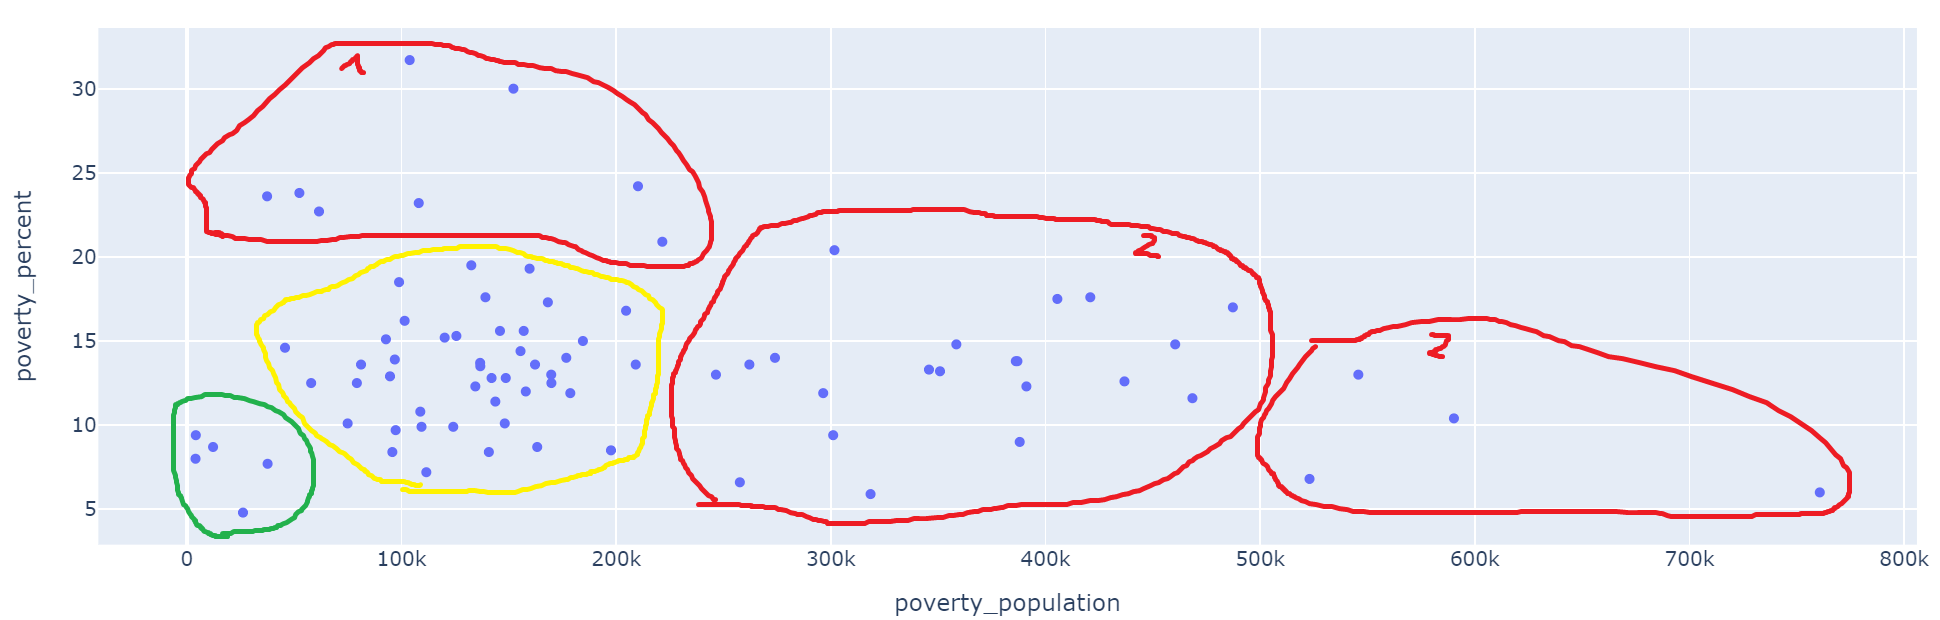

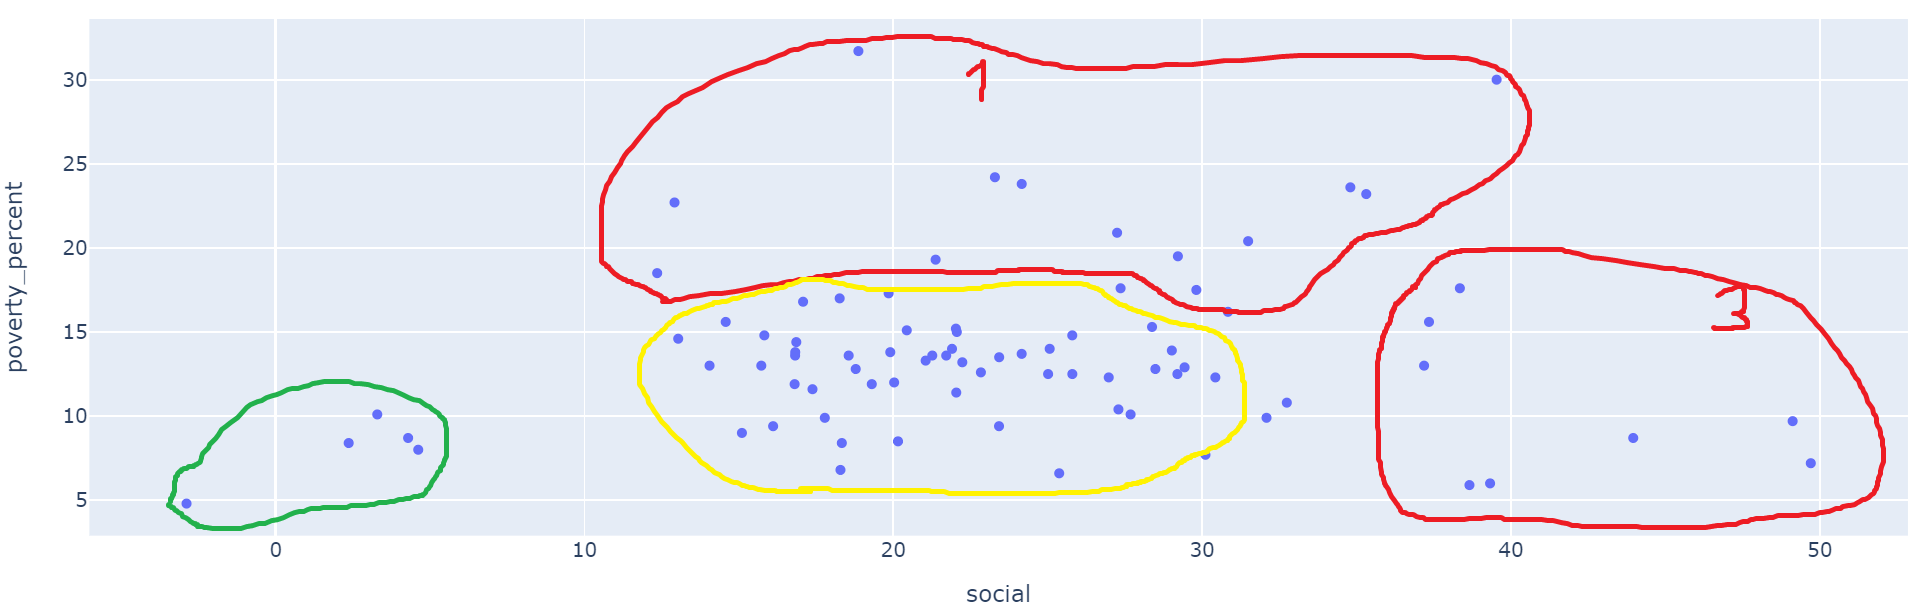

Про feature social обьясню позже

In [802]:
# Берем данные за 2020, чтобы делать выводы на 2021
test = main[main.year==2020].copy()

Я пробовал запускать кластеризацию по разроненным данным малообеспеченных/социально-незащищенных, но такой результат сложно интерперетировать.
Приведу ее в качестве baseline решения

## baseline

In [803]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

In [804]:
cluster_df

,year,poverty_percent,poverty_population,senior,disabled_percent,living_rooms,cramped_and_bad_conditions,counting_on_housing_from_gov
0,2020,7.20,111538.87,12.90,12.91,2.60,0.40,1.60
1,2020,13.60,162178.78,3.70,8.91,3.20,0.00,3.80
2,2020,12.50,169802.00,4.80,9.07,2.20,0.00,1.70
3,2020,8.50,197557.42,2.30,9.33,2.60,0.10,3.70
4,2020,13.70,136607.49,5.00,7.78,2.40,0.90,1.30
...,...,...,...,...,...,...,...,...
80,2020,15.20,120086.69,4.70,8.19,2.30,0.30,5.50
81,2020,8.70,12192.96,0.00,3.57,1.90,0.00,3.80
82,2020,7.70,37595.79,12.10,4.43,2.10,0.00,3.80
83,2020,23.60,37359.98,10.80,7.98,2.20,0.50,3.80


In [805]:
# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [806]:
# Определим число кластеров
from sklearn import metrics
from sklearn.cluster import KMeans
#проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0,0), 'CH': (0,0), 'DB':(0,100)}
for i in range(2,11):
	# обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters = i, random_state = 1 ).fit(X_pca)
	#предсказываем метки
    y_pred = km.labels_
	#выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca,y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print (i,new_sil,new_CH,new_DB)
    if new_sil>ans['sil'][1]:
        ans['sil'] = (i,new_sil)
    if new_CH>ans['CH'][1]:
        ans['CH'] = (i,new_CH)
    if new_DB<ans['DB'][1]:
        ans['DB'] = (i,new_DB)
print (ans)

2 0.2581978585857954 15.88295051384682 1.695682629427202
3 0.23806796526101626 17.501401061810487 1.534056609463134
4 0.1708217369612435 17.26233872176167 1.514791325605121
5 0.18893227215361547 17.229714691291452 1.407059320917494
6 0.20838855962880007 19.157825055837773 1.237039547817381
7 0.2144712343858518 18.86143003332352 1.181432689491487
8 0.2082604533605255 18.69195751901959 1.1053169869031967
9 0.22692634916608775 18.595424476593074 1.0631128899456281
10 0.18520278425342881 17.87087947682311 1.0474983735573964
{'sil': (2, 0.2581978585857954), 'CH': (6, 19.157825055837773), 'DB': (10, 1.0474983735573964)}


In [807]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat([cluster_res.reset_index(drop=True),save_region_data],axis=1)

In [808]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region':True})

Регионы как-то делятся на кластеры. Есть кластеры с большим процентом бедности и большим числом бедностей. Но как выделяются остальные кластеры разобрать сложно.

## Введение параметра социальной незащищенности social


Соберем собственную формулу "нуждаемости региона в помощи"

In [809]:
test = main[main.year==2020].copy()
# Собираем фактор социально-незащищенных: неработающих и с плохими условиями жилья. Формула подбиралась "на глаз", так чтобы лучше разделить регионы
test['social']=test['senior']*2+test.disabled_percent*2+(-test.living_rooms+test.cramped_and_bad_conditions-test.counting_on_housing_from_gov)/2
test = test.drop(['senior','disabled_percent','living_rooms','cramped_and_bad_conditions','counting_on_housing_from_gov'],axis=1)


In [810]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

# Определим число кластеров
from sklearn import metrics
from sklearn.cluster import KMeans
#проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0,0), 'CH': (0,0), 'DB':(0,100)}
for i in range(2,11):
	# обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters = i, random_state = 1 ).fit(X_pca)
	#предсказываем метки
    y_pred = km.labels_
	#выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca,y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print (i,new_sil,new_CH,new_DB)
    if new_sil>ans['sil'][1]:
        ans['sil'] = (i,new_sil)
    if new_CH>ans['CH'][1]:
        ans['CH'] = (i,new_CH)
    if new_DB<ans['DB'][1]:
        ans['DB'] = (i,new_DB)
print (ans)

2 0.2864087181488763 28.014062276467325 1.2239455833470028
3 0.31936651891394163 33.03401740863899 1.0848253594235022
4 0.3187658749764576 39.804321964685535 0.9765840076527974
5 0.3405364065975983 41.34072192569183 0.876737103115488
6 0.3108976005609313 39.57914146263274 0.8992317228592238
7 0.31448730170254974 40.56606532852598 0.8986472803550508
8 0.30375857991010774 39.13320658579019 0.9269985246446437
9 0.2708649431525536 37.7969887036597 0.90887912290069
10 0.264398283838606 36.59970214389194 1.0109547686677944
{'sil': (5, 0.3405364065975983), 'CH': (5, 41.34072192569183), 'DB': (5, 0.876737103115488)}


Круто, что по метрикам выделется именно 5 кластеров, как хотелось

In [811]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat([cluster_res.reset_index(drop=True),save_region_data],axis=1)

In [812]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region':True})

In [813]:
px.scatter(cluster_res, x = 'social', y='poverty_percent', color='cluster',
           hover_data={'region':True})

In [814]:
px.scatter_3d(cluster_res, x = 'poverty_population', z='poverty_percent', y = 'social', color='cluster',
           hover_data={'region':True})

Получилось?! Есть кластеры:
1) с наибольшим процентом бедных - 4
2) наибольшим количеством бедных - 1
3) наиболее социально-незащищенных -3
4) в безопасности - 2
5) промежуточный - 0

In [815]:
# Сохраняю df на всякий случай
pd.to_pickle(main,'main.pkl')


In [816]:
main=pd.read_pickle('main.pkl')

## Прогноз

Продлим основные ряды процента бедных и популяции до 2021 года

### Принцип алгоритма для одного региона


In [817]:
poverty_percent_to_2021 = main[main['region']=='Белгородская область'].iloc[:,1:3]
poverty_percent_to_2021.set_index('year',inplace=True)
poverty_percent_to_2021

,poverty_percent
year,
1995,19.90
1996,17.60
1997,18.90
1998,20.10
1999,24.20
2000,33.60
2001,29.10
2002,25.40
2003,22.90


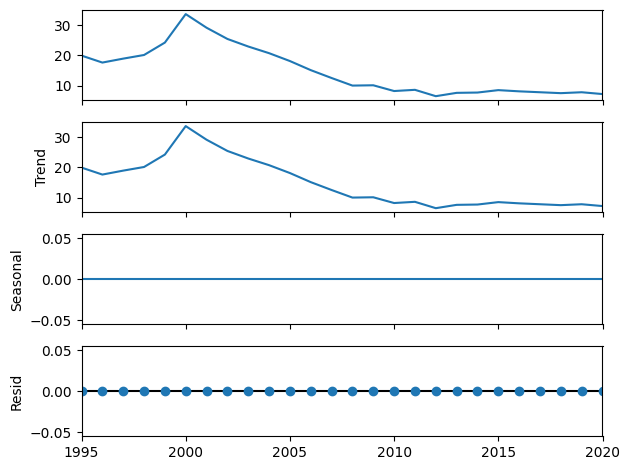

In [818]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(poverty_percent_to_2021, period =1)
fig = decomposition.plot()
plt.show()

In [819]:
# Данные делим по порядку
train_df = poverty_percent_to_2021.iloc[:-1]
test_df = poverty_percent_to_2021.iloc[-1:]
train_df.shape, test_df.shape

((25, 1), (1, 1))

In [820]:
# Стационарность
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    test1 = adfuller(df)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

adfuller_test(train_df)

adf:  -2.419827764101763
p-value:  0.13621819003466573
Critical values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Ряд нестационарен


In [821]:
# Автоподбор параметров
import pmdarima as pm
smodel = pm.auto_arima(
    train_df,
    start_p=0,
    d=None,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True
)
smodel_fit = smodel.fit(train_df)
# Предсказание AR
ar_pred = smodel_fit.predict(1)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=124.852, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=123.918, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=121.206, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=123.182, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.217 seconds


In [822]:
# Предсказание экспонентой
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

25   7.75
dtype: float64

In [823]:
# Сравнение результатов
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(test_df, ar_pred)*100, mean_absolute_percentage_error(test_df, exp_pred)*100)

6.100747921625478 7.586464141194152


### Проверю, насколько хорошо предсказываются значения для всех регионов

In [824]:
test_pred = {'region':[], 'y_test':[], 'pred':[], "MAPE":[]} # Сохранял получающиеся значения для оценки. Не необходимо, но интересно
for region in main.region.unique():

    test_pred['region'].append(region)
    poverty_percent_to_2021 = main[main['region']==region].iloc[:,1:3]
    poverty_percent_to_2021.set_index('year',inplace=True)

    train_df = poverty_percent_to_2021.iloc[:-1]
    test_df = poverty_percent_to_2021.iloc[-1:]
    test_pred['y_test'].append(test_df.values[0])
    
    smodel = pm.auto_arima(
        train_df,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(train_df)
    ar_pred = smodel_fit.predict(1)
    
    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(train_df)
    model = ses.fit(smoothing_level = 0.7, optimized = False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0],np.array(exp_pred)[0]))
    test_pred['pred'].append(pred)
    
    test_pred['MAPE'].append(mean_absolute_percentage_error(test_df.values[0], [pred]).round(4)*100)

test_pred_df = pd.DataFrame(test_pred)
print(f'Средний MAPE для предсказаний: {test_pred_df.MAPE.mean()}')

Средний MAPE для предсказаний: 3.094235294117647


Хороший результат. Сделаем предсказания для 2021 года и добавим в main 

### Предсказания poverty_percent на 2021

In [825]:
pred_dic = {'region':[], 'poverty_percent':[]}
for region in main.region.unique():
    
    pred_dic['region'].append(region)

    poverty_percent_to_2021 = main[main['region']==region].iloc[:,1:3]
    poverty_percent_to_2021.set_index('year',inplace=True)

    smodel = pm.auto_arima(
        poverty_percent_to_2021,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(poverty_percent_to_2021)
    ar_pred = smodel_fit.predict(1)
    
    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(poverty_percent_to_2021)
    model = ses.fit(smoothing_level = 0.7, optimized = False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0],np.array(exp_pred)[0]))
    pred_dic['poverty_percent'].append(pred)

pred_df = pd.DataFrame(pred_dic)    

In [826]:
# В сделанном ранее df c популяциями есть 2021 год
pred_df = pred_df.merge(pop_df[pop_df['year']==2021])

In [827]:
pred_df['poverty_population'] = pred_df['poverty_percent']/100 * pred_df['population']
pred_df.drop(['population','year'],axis =1)

,region,poverty_percent,poverty_population
0,Белгородская область,7.20,110970.65
1,Брянская область,13.40,158479.39
2,Владимирская область,12.40,166420.28
3,Воронежская область,8.50,195976.68
4,Ивановская область,13.20,130288.22
...,...,...,...
80,Амурская область,14.70,114931.36
81,Магаданская область,8.70,12095.96
82,Сахалинская область,7.30,35448.33
83,Еврейская автономная область,23.55,36863.33


## Кластеризация с предсказанными значениями бедностей

In [828]:
test = main[main.year==2020].drop(['poverty_population','poverty_percent'],axis = 1).merge(pred_df.drop(['population','year'],axis =1),on='region')
test['social']=test['senior']*2+test.disabled_percent*2+(-test.living_rooms+test.cramped_and_bad_conditions-test.counting_on_housing_from_gov)/2
test = test.drop(['senior','disabled_percent','living_rooms','cramped_and_bad_conditions','counting_on_housing_from_gov'],axis=1)

In [829]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [830]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res['pred_cluster'] = kmeans.labels_

In [831]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='pred_cluster',
           hover_data={'region':True})

Курганская область ушла из кластера наибольшего процента бедности. Минимальное, конечно, изменение, но всё же значимо
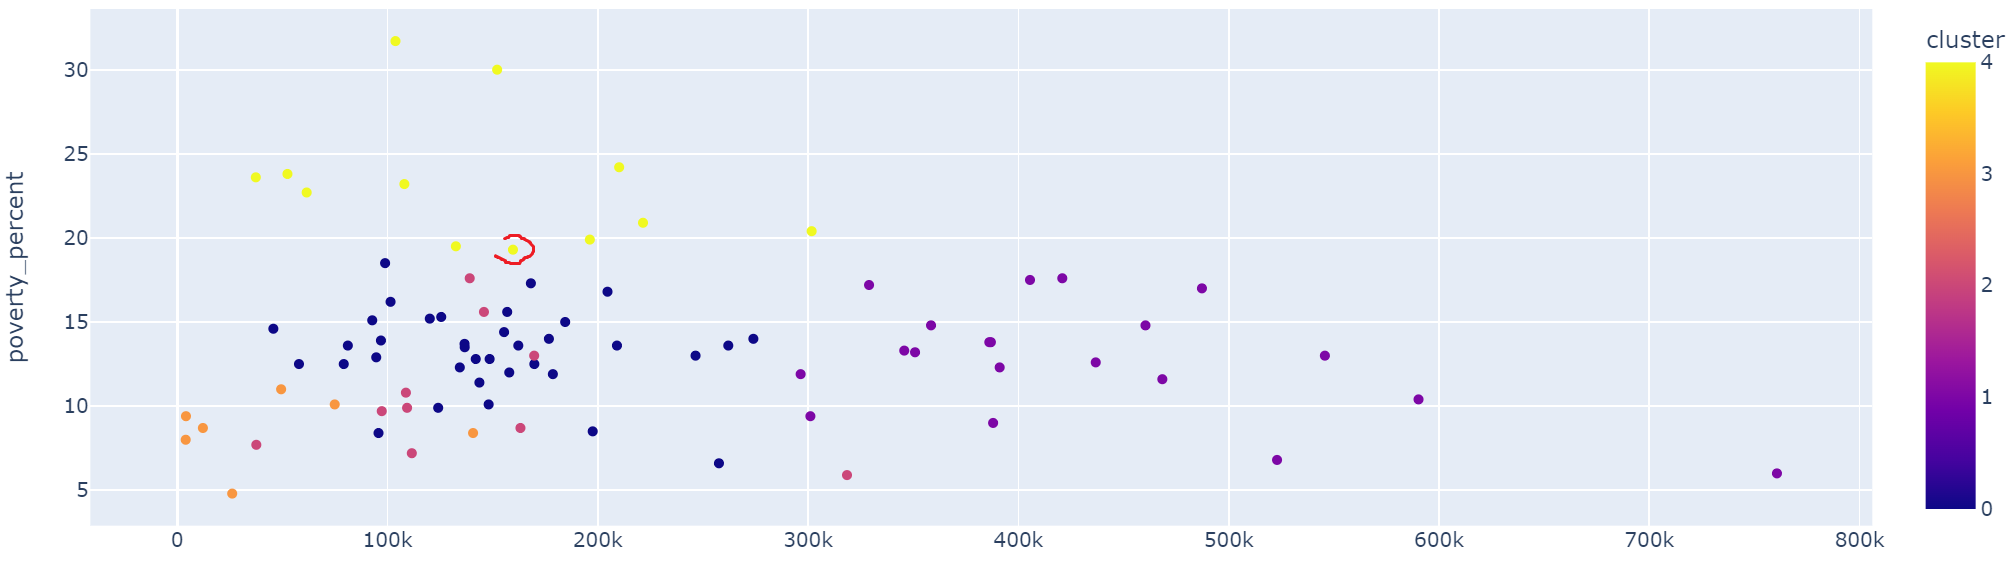
(график на цифрах 2020 года)

In [832]:
px.scatter_3d(cluster_res, x = 'poverty_population', z='poverty_percent', y = 'social', color='pred_cluster',
           hover_data={'region':True})

Зафиксируем
1) с наибольшим процентом бедных - 3
2) наибольшим количеством бедных - 2
3) наиболее социально-незащищенных -0
4) в безопасности - 4
5) промежуточный - 1

In [833]:
cluster_res

,year,poverty_percent,poverty_population,social,cluster,region,pred_cluster
0,2020,7.20,111538.87,49.71,2,Белгородская область,0
1,2020,13.60,162178.78,21.71,0,Брянская область,1
2,2020,12.50,169802.00,25.80,0,Владимирская область,1
3,2020,8.50,197557.42,20.15,0,Воронежская область,1
4,2020,13.70,136607.49,24.16,0,Ивановская область,1
...,...,...,...,...,...,...,...
80,2020,15.20,120086.69,22.03,0,Амурская область,1
81,2020,8.70,12192.96,4.29,3,Магаданская область,4
82,2020,7.70,37595.79,30.11,2,Сахалинская область,0
83,2020,23.60,37359.98,34.80,4,Еврейская автономная область,3


In [834]:
lib = cluster_res.groupby('pred_cluster').agg({'region':[tuple,len],
                                                           'poverty_percent':np.mean,
                                                           'poverty_population':np.mean
                                                           ,'social':np.mean})
lib

region      \
                                                          tuple len   
pred_cluster                                                          
0             (Белгородская область, Калужская область, Курс...  10   
1             (Брянская область, Владимирская область, Ворон...  37   
2             (Московская область, Город Москва, Республика ...  20   
3             (Республика Калмыкия, Республика Ингушетия, Ка...  11   
4             (Ненецкий автономный округ, Мурманская область...   7   

             poverty_percent poverty_population social  
                        mean               mean   mean  
pred_cluster                                            
0                      10.61          140073.72  38.93  
1                      13.43          149317.29  21.80  
2                      12.80          431619.13  22.02  
3                      23.63          143379.80  27.13  
4                       8.63           44493.65   5.52

# Сравним кластеры

In [835]:
from scipy.stats import shapiro

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

data =cluster_res.drop(['cluster', 'region', 'year'], axis =1)
for col in data.columns[:3]:
	print (col)
	_, p = shapiro(data[col])
	print('p=%.3f' % p)

	# Интерпретация 

	if p > alpha:
		print(H0)
	else:
		print(Ha)

poverty_percent
p=0.000
Данные не распределены нормально (мы отвергаем H0)
poverty_population
p=0.000
Данные не распределены нормально (мы отвергаем H0)
social
p=0.163
Данные распределены нормально


array([[<AxesSubplot: title={'center': 'poverty_percent'}>,
        <AxesSubplot: title={'center': 'poverty_population'}>],
       [<AxesSubplot: title={'center': 'social'}>,
        <AxesSubplot: title={'center': 'pred_cluster'}>]], dtype=object)

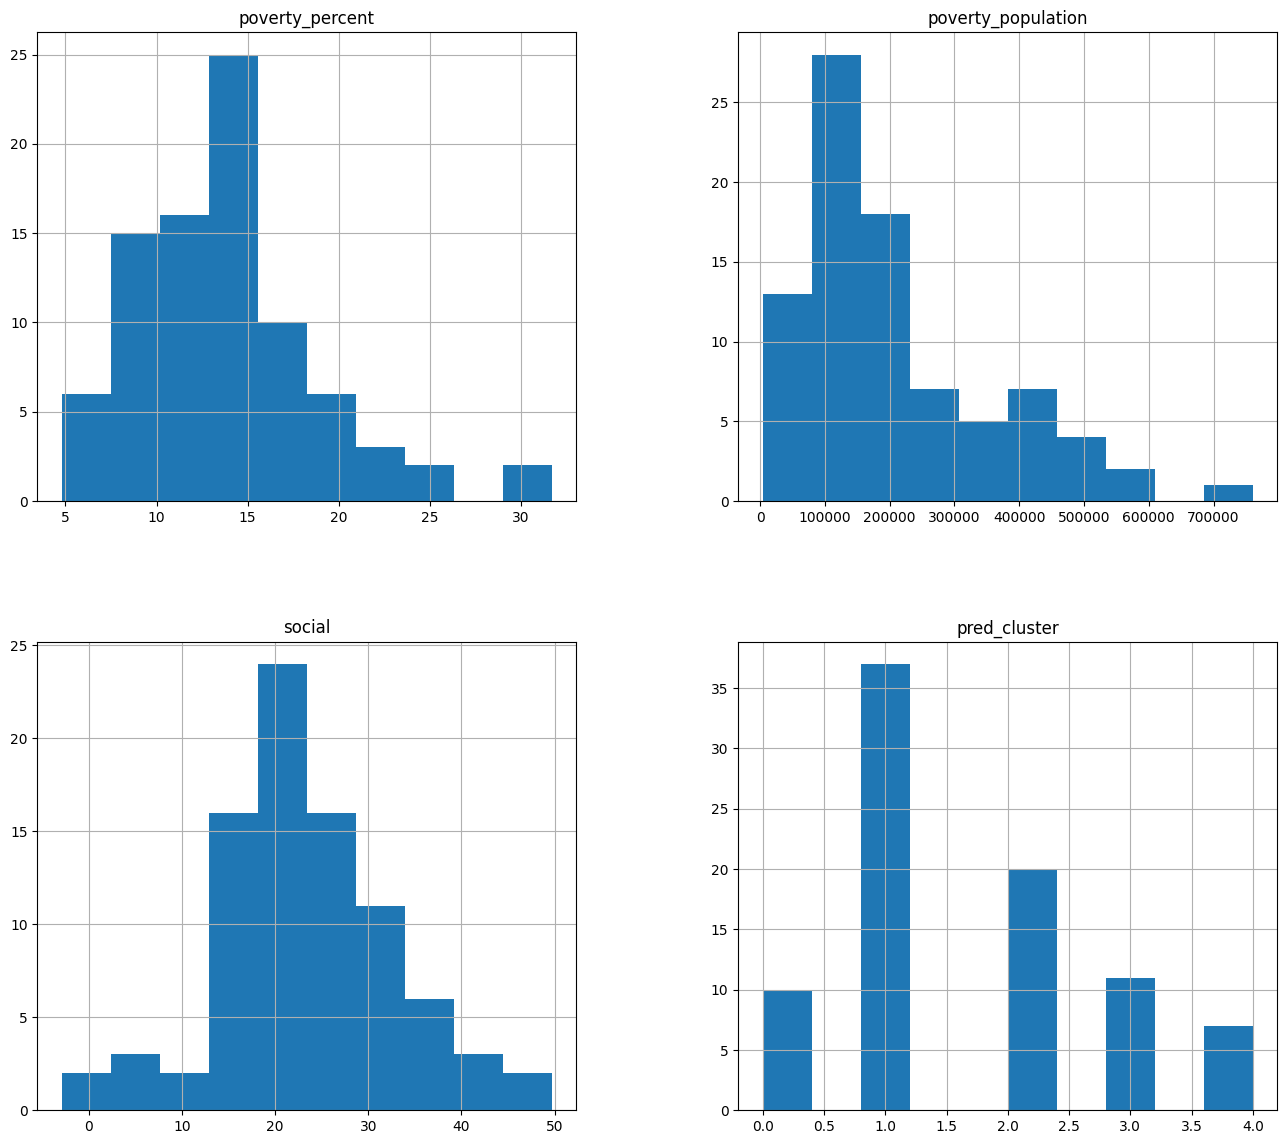

In [836]:
data.hist(figsize=(16,14))

Значит для первых двух признаков используем тест суммы рангов Вилкоксона, для третьего - Независимый T-тест. Сравним выделяющиеся по этим признакам кластеры с "безопасным"

In [837]:
from scipy.stats import ranksums



def wilk(df, cluster, parameter):

    H0 = f', а значит {parameter} в определяемом кластере {cluster} не отличается от его же в среднем кластере\n'
    Ha = f', а значит {parameter} в определяемом кластере {cluster} больше, чем в среднем\n'

    print('\n' + "*** Результаты теста суммы рангов Вилкоксона ***")
    test_results = ranksums(df[df['pred_cluster']==cluster][parameter], df[df['pred_cluster']==1][parameter], alternative='greater')

    p = round(test_results[1],2)

    if p>alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу{H0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу{Ha}")


print('Проверим, что относительная бедность в кластере 3 больше, чем в "среднем" кластере 1')
wilk(data, 3, 'poverty_percent')
print('Проверим, что абсолютное число малоимущих в кластере 2 больше, чем в "среднем" кластере 1')
wilk(data, 2, 'poverty_population')


Проверим, что относительная бедность в кластере 3 больше, чем в "среднем" кластере 1

*** Результаты теста суммы рангов Вилкоксона ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу, а значит poverty_percent в определяемом кластере 3 больше, чем в среднем

Проверим, что абсолютное число малоимущих в кластере 2 больше, чем в "среднем" кластере 1

*** Результаты теста суммы рангов Вилкоксона ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу, а значит poverty_population в определяемом кластере 2 больше, чем в среднем



In [838]:
from scipy.stats import ttest_ind
def t_test(df, cluster, parameter):

    H0 = f', а значит {parameter} в определяемом кластере {cluster} не отличается от его же в среднем кластере\n'
    Ha = f', а значит {parameter} в определяемом кластере {cluster} больше, чем в среднем\n'

    print('\n' + "*** Результаты независимого T-теста ***")
    test_results = ttest_ind(df[df['pred_cluster']==cluster][parameter], df[df['pred_cluster']==1][parameter], alternative='greater')

    p = round(test_results[1],2)

    if p>alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу{H0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу{Ha}")


print('Проверим, что социальное неблагополучие в кластере 0 больше, чем в "среднем" кластере 1')
t_test(data, 0, 'social')

Проверим, что социальное неблагополучие в кластере 0 больше, чем в "среднем" кластере 1

*** Результаты независимого T-теста ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу, а значит social в определяемом кластере 0 больше, чем в среднем



#  Экономика

## Валовой региональный продукт

In [839]:
main = pd.read_pickle('main.pkl')

In [840]:
grp_df = pd.read_excel('data/gross_regional_product_1996_2020.xls', skiprows=[0,1])
grp_df = grp_df.rename({grp_df.columns[0]: 'region'}, axis = 1)
grp_df = unified_regions(grp_df)
# конвертируем таблицу wide-to-long
grp_df = pd.melt(grp_df,id_vars='region',var_name='year',value_name='grp_value')
grp_df.year = grp_df.year.apply(int)
grp_df

,region,year,grp_value
0,Белгородская область,1996,9575.60
1,Брянская область,1996,7275.30
2,Владимирская область,1996,7620.70
3,Воронежская область,1996,7651.90
4,Ивановская область,1996,6725.40
...,...,...,...
2120,Амурская область,2020,571362.10
2121,Магаданская область,2020,2035007.00
2122,Сахалинская область,2020,2059206.50
2123,Еврейская автономная область,2020,400340.50


In [841]:
grp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     2125 non-null   object 
 1   year       2125 non-null   int64  
 2   grp_value  2111 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 49.9+ KB


In [842]:
grp_df.grp_value.value_counts(dropna=False)

grp_value
0.00          106
NaN            14
9575.60         1
4035943.20      1
281021.60       1
             ... 
69629.50        1
48464.80        1
96240.20        1
45955.10        1
2404271.20      1
Name: count, Length: 2007, dtype: int64

В данных есть пропуски и нули. К сожалению, на слишком больших промежутках, чтобы как-то разумно их заменить. Заменим 0 на NA

In [843]:
grp_df = grp_df.replace(0,np.nan).dropna(how='any', axis=0)

In [844]:
set(main.region.unique())-(set(disabled.region.unique()))

set()

In [845]:
main = main.merge(grp_df, how='left', on=['region','year'])
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered') 

Прослеживается зависимость процента бедности от ВРП

In [846]:
px.scatter(main, y ='poverty_percent', x='grp_value', log_y=True, hover_data=['region','year'])

Может даже логарифмическая зависимость? Что если убрать крайние значения?

In [847]:
main.grp_value.quantile([0.1, 0.9])

0.10    14021.75
0.90   505276.80
Name: grp_value, dtype: float64

In [848]:
vis = main[main.grp_value.between(14004.32, 509867.48)]
px.imshow(vis.corr(numeric_only=True),color_continuous_scale='Bluered')

In [849]:
fig = px.scatter(vis, y ='poverty_percent', x='grp_value', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     2140.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          8.31e-297
Time:                        21:40:28   Log-Likelihood:                -5346.4
No. Observations:                1593   AIC:                         1.070e+04
Df Residuals:                    1591   BIC:                         1.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.9525      2.098     56.211      0.000     113.837     122.068
x1           -19.0690      0.412    -46.265      0.000     -19.877     -18.261
==============================================================================
Omnibus:                      261.478   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.477
Skew:                           0.838   Prob(JB):                    6.68e-169
Kurtosis:                       5.977   Cond. No.                         63.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Есть явная зависимость бедности региона от значения ВРП

## Оборот розничной торговли на душу населения

In [850]:
retail_turnover = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', skiprows=[0,1,3])
retail_turnover

,Unnamed: 0,Unnamed: 1,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Российская Федерация,рубль,16046.00,21031.00,25913.00,31557.00,39166.00,49063.00,60901.00,76111.00,...,149401.00,165051.00,180410.00,188017.00,192541.00,202568.00,215074.00,229104.00,231283.00,270606.00
1,Центральный федеральный округ,рубль,26062.00,33630.00,40010.00,46760.00,57011.00,68302.00,81774.00,97965.00,...,188757.00,207394.00,231873.00,237737.00,243426.00,258278.00,277011.00,296368.00,301192.00,354141.00
2,Белгородская область,рубль,11820.00,13837.00,16366.00,19222.00,24168.00,30174.00,41387.00,55460.00,...,129904.00,144992.00,164079.00,178097.00,192504.00,203298.00,217059.00,230704.00,237076.00,259151.00
3,Брянская область,рубль,8267.00,10951.00,14312.00,17988.00,22849.00,28892.00,36931.00,48448.00,...,121136.00,138669.00,158501.00,177048.00,179767.00,192775.00,209987.00,225818.00,225643.00,257679.00
4,Владимирская область,рубль,7442.00,9403.00,10984.00,13357.00,16584.00,21140.00,29719.00,42497.00,...,103848.00,116202.00,129564.00,139408.00,143643.00,153088.00,164519.00,175251.00,177680.00,207670.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Магаданская область,рубль,14806.00,19700.00,24101.00,29511.00,33831.00,40935.00,49440.00,59698.00,...,126320.00,153398.00,174694.00,187765.00,202541.00,213558.00,226312.00,240162.00,245817.00,289171.00
104,Сахалинская область,рубль,14152.00,21250.00,28378.00,35556.00,45754.00,59836.00,82315.00,98458.00,...,209149.00,228920.00,250253.00,272527.00,276476.00,289573.00,303112.00,327601.00,338787.00,364356.00
105,Еврейская автономная область,рубль,9198.00,13088.00,18310.00,23575.00,31193.00,39171.00,45012.00,51274.00,...,98243.00,108408.00,117276.00,133748.00,134162.00,138444.00,149572.00,165356.00,168066.00,188492.00
106,Чукотский автономный округ,рубль,13723.00,22132.00,32979.00,38253.00,41111.00,41405.00,45132.00,52030.00,...,113267.00,108218.00,102795.00,119335.00,154019.00,183781.00,193391.00,209839.00,217089.00,225671.00


In [851]:
retail_turnover = retail_turnover.drop(retail_turnover.columns[1], axis=1)

In [852]:
retail_turnover = retail_turnover.rename({retail_turnover.columns[0]: 'region'}, axis = 1)
retail_turnover = unified_regions(retail_turnover)

In [853]:
# конвертируем таблицу wide-to-long
retail_turnover_df = pd.melt(retail_turnover,id_vars='region',var_name='year',value_name='retail_turnover')
retail_turnover_df.year = retail_turnover_df.year.apply(int)

In [854]:
set(main.region.unique())-(set(retail_turnover_df.region.unique()))

set()

In [855]:
main = main.merge(retail_turnover_df, how='left', on=['region','year'])

In [856]:
main.retail_turnover.value_counts(dropna=False)

retail_turnover
NaN          395
0.00          52
176420.00      2
140782.00      2
83032.00       2
            ... 
127898.00      1
115337.00      1
103067.00      1
85525.00       1
217089.00      1
Name: count, Length: 1708, dtype: int64

При просмотре получившейся таблицы видно, что 0 это данные в областях-матрёшках. Можно вычислить эти значения, но довольно муторно. Думаю можно пропустить эти строчки. NaN для годов раньше 1999 тоже опустим, остальные заменим первым валидным значением

In [857]:
vis = main[main['retail_turnover']!=0]
vis = vis[vis['year']>1999]
vis['retail_turnover'] = vis['retail_turnover'].bfill()
px.imshow(vis.corr(numeric_only=True),color_continuous_scale='Bluered') 

In [858]:
px.scatter(vis, y ='poverty_percent', x='retail_turnover', hover_data=['region','year'])

Как же приятно работать с такими корреляциями! Попробуем аппроксимировать

In [859]:
fig = px.scatter(vis, y ='poverty_percent', x='retail_turnover', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     3561.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:40:29   Log-Likelihood:                -5658.9
No. Observations:                1731   AIC:                         1.132e+04
Df Residuals:                    1729   BIC:                         1.133e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6387      1.783     70.465      0.000     122.142     129.136
x1           -21.8116      0.366    -59.671      0.000     -22.528     -21.095
==============================================================================
Omnibus:                      491.305   Durbin-Watson:                   1.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2761.050
Skew:                           1.211   Prob(JB):                         0.00
Kurtosis:                       8.694   Cond. No.                         59.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [860]:
fig = px.scatter(vis, y ='poverty_percent', x='retail_turnover', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     3561.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:40:29   Log-Likelihood:                -5658.9
No. Observations:                1731   AIC:                         1.132e+04
Df Residuals:                    1729   BIC:                         1.133e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6387      1.783     70.465      0.000     122.142     129.136
x1           -21.8116      0.366    -59.671      0.000     -22.528     -21.095
==============================================================================
Omnibus:                      491.305   Durbin-Watson:                   1.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2761.050
Skew:                           1.211   Prob(JB):                         0.00
Kurtosis:                       8.694   Cond. No.                         59.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Видим, что оборот розничной торговли также коррелирует с процентом бедности в регионе. Хотя он и с ВРП достаточно скоррелирован (0.5)

# Выводы

## Проведен разведывательный анализ данных, найдены зависимости, такие как

В среднем, после 2000 года каждый год относительные и абсолютные значения бедности уменьшаются, а экономические показатели растут
В малообеспеченных регионах:
* хуже жилищные условия
* хуже экономические показатели
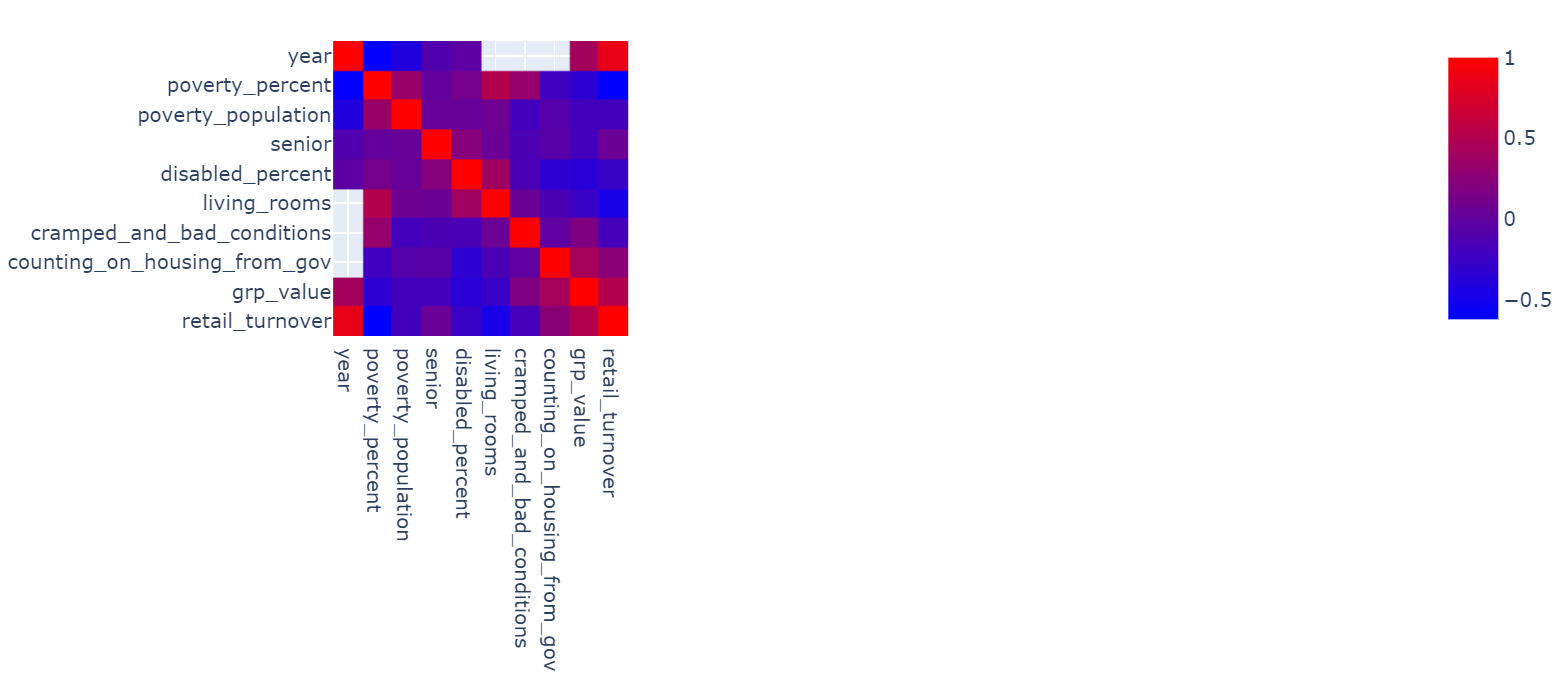

# Проведена кластеризация регионов

Определены кластеры регионов, которые наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения
* Наибольшее относительное число малообеспеченных

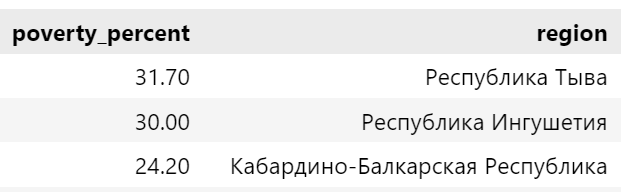

* Наибольшее абсолютное число малообеспеченных

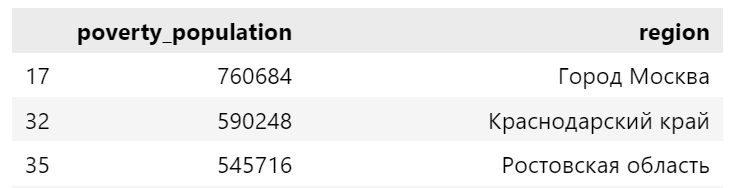

* Выше социальные трудности в регионах:

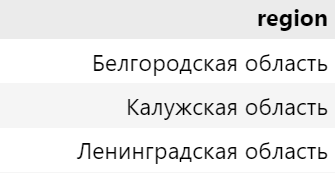

# Определение кластеров регионов подтверждено статистическими методами